In [2]:
import os
import cv2
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

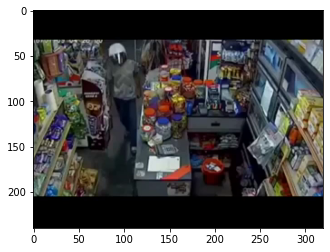

In [3]:
#visualizing the dataset
video_reader = cv2.VideoCapture("./Anomaly-Videos-Part-3/Robbery/"+os.listdir("./Anomaly-Videos-Part-3/Robbery")[0])
_,bgr_frame = video_reader.read()
video_reader.release()
rgb = cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

In [53]:
IMAGE_WIDTH, IMAGE_HEIGHT = 64,64
SEQUENCE_LENGTH = 20
DATASET_PATH = "Anomaly-Videos-Part-3"
CLASSES = ["Robbery","RoadAccidents","Testing_Normal_Videos_Anomaly"]

In [54]:
def getFrames(videoPath):
    Frames = []
    video_reader = cv2.VideoCapture(videoPath)
    videoFrameCount = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skipFrameWindow = max(int(videoFrameCount/SEQUENCE_LENGTH),1)
    for frameCounter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES,frameCounter*skipFrameWindow)
        success,frame = video_reader.read()
        if not success:
            break
        resizedFrame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
        normalizedFrame = resizedFrame/255
        Frames.append(normalizedFrame)
    video_reader.release()
    return Frames

In [61]:
# frames = getFrames("./Anomaly-Videos-Part-3/Robbery/"+os.listdir("./Anomaly-Videos-Part-3/Robbery")[0])
def createDataset():
    features = []
    labels = []
    videoPaths = []
    for classIndex, className in enumerate(CLASSES):
        print (f'Extracting data from {className}')

        filesList= os.listdir(os.path.join(DATASET_PATH, className))
        for fileName in filesList:
            videoPath = os.path.join(DATASET_PATH, className,fileName)
            videoFrames = getFrames(videoPath)

            if len(videoFrames) == SEQUENCE_LENGTH:
                features.append(videoFrames)
                labels.append(classIndex)
                videoPaths.append(videoPath)

    features = np.asarray(features)
    labels = np.asarray(labels)
    return features, labels, videoPaths 


In [62]:
features, labels, videoPaths  = createDataset() 

Extracting data from Robbery
Extracting data from RoadAccidents
Extracting data from Testing_Normal_Videos_Anomaly


In [63]:
oneHotEncodeLabels = to_categorical(labels)


In [70]:
'''Train Test Split'''
featuresTrain, featuresTest, labelsTrain, labelsTest = train_test_split(
    features, oneHotEncodeLabels, test_size=0.25, shuffle=True
)

In [65]:
def ConvLstmModel():
    model = Sequential([
    layers.ConvLSTM2D(filters = 4, kernel_size = (3,3), activation = "tanh", data_format = "channels_last", recurrent_dropout = 0.2, return_sequences = True,  input_shape = (SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3)),
    layers.MaxPooling3D(pool_size = (1,2,2), padding = "same", data_format = "channels_last"),
    layers.TimeDistributed(layers.Dropout(0.2)),

    layers.ConvLSTM2D(filters = 8, kernel_size = (3,3), activation = "tanh", data_format = "channels_last", recurrent_dropout = 0.2, return_sequences = True),
    layers.MaxPooling3D(pool_size = (1,2,2), padding = "same", data_format = "channels_last"),
    layers.TimeDistributed(layers.Dropout(0.2)),

    layers.ConvLSTM2D(filters = 14, kernel_size = (3,3), activation = "tanh", data_format = "channels_last", recurrent_dropout = 0.2, return_sequences = True),
    layers.MaxPooling3D(pool_size = (1,2,2), padding = "same", data_format = "channels_last"),
    layers.TimeDistributed(layers.Dropout(0.2)),

    layers.ConvLSTM2D(filters = 16, kernel_size = (3,3), activation = "tanh", data_format = "channels_last", recurrent_dropout = 0.2, return_sequences = True),
    layers.MaxPooling3D(pool_size = (1,2,2), padding = "same", data_format = "channels_last"),

    #dense layer
    layers.Flatten(),
    layers.Dense(len(CLASSES), activation = "softmax")])

    model.summary()
    return model

In [66]:
lstmModel = ConvLstmModel()
print("Model Created!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_7 (ConvLSTM2D)  (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 20, 31, 31, 4)    0         
 3D)                                                             
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 31, 31, 4)    0         
 tributed)                                                       
                                                                 
 conv_lstm2d_8 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                      

In [67]:
EarlyCallback = EarlyStopping(monitor="val_loss", patience = 10, mode = "min", restore_best_weights= True)

lstmModel.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

modelTrainingHistory = lstmModel.fit(x = featuresTrain, y = labelsTrain, epochs = 50, batch_size = 4, shuffle = True, validation_split = 0.2, callbacks = [EarlyCallback])

Epoch 1/50
41/41 [==============================] - 111s 2s/step - loss: 0.9768 - accuracy: 0.5309 - val_loss: 0.9391 - val_accuracy: 0.4146
Epoch 2/50
41/41 [==============================] - 88s 2s/step - loss: 0.9042 - accuracy: 0.5864 - val_loss: 1.0169 - val_accuracy: 0.4146
Epoch 3/50
41/41 [==============================] - 87s 2s/step - loss: 0.8750 - accuracy: 0.5926 - val_loss: 1.0404 - val_accuracy: 0.4146
Epoch 4/50
41/41 [==============================] - 87s 2s/step - loss: 0.8781 - accuracy: 0.5926 - val_loss: 0.9527 - val_accuracy: 0.4146
Epoch 5/50
41/41 [==============================] - 99s 2s/step - loss: 0.8385 - accuracy: 0.5926 - val_loss: 0.8312 - val_accuracy: 0.6341
Epoch 6/50
41/41 [==============================] - 127s 3s/step - loss: 0.7535 - accuracy: 0.7037 - val_loss: 1.6086 - val_accuracy: 0.4146
Epoch 7/50
41/41 [==============================] - 87s 2s/step - loss: 0.8164 - accuracy: 0.6481 - val_loss: 0.8064 - val_accuracy: 0.7073
Epoch 8/50
41/41 [

In [68]:
evaluationHistory = lstmModel.evaluate(featuresTest, labelsTest)

3/3 [==============================] - 5s 1s/step - loss: 0.7345 - accuracy: 0.7059


In [71]:
labelPred = lstmModel.predict(features[:30])

1/1 [==============================] - 5s 5s/step


In [72]:
for probabilities in labelPred:
    print(CLASSES[np.argmax(probabilities)])

Robbery
Robbery
Testing_Normal_Videos_Anomaly
Robbery
Testing_Normal_Videos_Anomaly
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery
Robbery


The following jupyter notebook is my first approach at trying to recognize robbery from CCTV footage using deep learning techniques. The methodolgy used in this project is the use of CNN and LSTM to perform Spatial and Temporal analysis to detect the action from three different types of activities namely Robbery, Road Accidents and Normal videos. The dataset used is the UCF crime dataset and the results of this attempt indicate 96% training accuracy and 73% test accuracy.